In [5]:
import fitz  # PyMuPDF
from PIL import Image
import pytesseract
import io
import cv2
import numpy as np
import re
import language_tool_python

# Initialize LanguageTool for Spanish
tool = language_tool_python.LanguageTool('es')

# Path to your PDF file
pdf_path = 'books/test2.pdf'

def preprocess_with_opencv(img):
    """
    Preprocess the image using OpenCV, excluding deskewing.
    """
    # Convert to grayscale
    img_gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    # Apply Gaussian blur
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    # Apply Otsu's binarization
    _, img_binary = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img_binary

def detect_page_number(text):
    """
    Detect lines that likely contain page numbers.
    """
    removal_values = []
    lines = text.splitlines()
    for line in lines:
        # Strip leading/trailing whitespace
        stripped_line = line.strip()
        
        # Regex to match patterns like "Page 1", "1 / 100", or numeric-only lines
        if re.match(r"^(page\s*\d+|\d+\s*/\s*\d+|\d+)$", stripped_line, re.IGNORECASE):
            removal_values.append(line)
    
    return removal_values

def clean_text(text):
    """
    Clean the extracted OCR text to remove nonsensical lines and improve output quality,
    while preserving meaningful punctuation.
    """
    # Store the original and cleaned lines in a dictionary
    lines = text.splitlines()
    modified_lines = {}

    for line in lines:
        # Keep the original line
        original_line = line

        # Start with the assumption that the line is clean
        cleaned_line = original_line.strip()

        # Remove lines with mostly non-alphanumeric characters
        if len(re.findall(r'[a-zA-Z0-9]', cleaned_line)) / max(len(cleaned_line), 1) < 0.5:
            cleaned_line = ""

        # Remove lines that are too short (e.g., isolated symbols)
        if len(cleaned_line) < 3:
            cleaned_line = ""

        # Remove excessive repeated characters (e.g., "aaaaaa" or "!!!!")
        if re.match(r"(.)\1{3,}", cleaned_line):
            cleaned_line = ""

        # Keep meaningful punctuation while removing stray symbols
        # Allow common Spanish punctuation and symbols
        cleaned_line = re.sub(r"[^\w\s,.!?¿¡:\"'()-]", "", cleaned_line)

        # If the line changes, store it in the dictionary
        if original_line != cleaned_line:
            modified_lines[original_line] = cleaned_line

    # Replace only the modified lines in the original text
    for original, cleaned in modified_lines.items():
        text = text.replace(original, cleaned)

    return text

def normalize_newlines(text):
    """
    Normalize newline characters:
    - Replace single '\n' with a space.
    - Replace consecutive '\n\n' or more with a single '\n\n'.
    """
    # Replace single newlines surrounded by non-newline characters with a space
    text = re.sub(r"(?<!\n)\n(?!\n)", " ", text)
    # Replace multiple newlines with a double newline
    text = re.sub(r"\n{2,}", "\n\n", text)
    return text

def remove_short_lines_in_place(text):
    """
    Remove lines directly from the text that have no words with more than three characters,
    without splitting and rejoining the text.
    :param text: The input text.
    :return: The cleaned text with unwanted lines removed.
    """
    result = []
    start = 0
    length = len(text)
    while start < length:
        # Find the end of the current line
        end = text.find('\n', start)
        if end == -1:
            end = length

        line = text[start:end].strip()
        
        # Determine if the current line ends with a hyphen
        previous_line_ended_with_hyphen = line.endswith("-")

        if previous_line_ended_with_hyphen:
            # Remove the hyphen and concatenate with this line
            result[-1] = result[-1] + line
        else:
            result.append(line)

        

        # Move to the next line
        start = end + 1


    # Reassemble the text from the valid lines in the result
    return "\n".join(result)

# Initialize an empty list to hold the text for each page
pages_text = []

def is_meaningful_text(text, min_length=10, min_alpha_ratio=0.5):
    """
    Check if the text is meaningful based on length and alphanumeric ratio.
    :param text: The text to check.
    :param min_length: Minimum length for the text to be considered meaningful.
    :param min_alpha_ratio: Minimum ratio of alphanumeric characters.
    :return: True if the text is meaningful, False otherwise.
    """
    # Remove whitespace
    stripped_text = text.strip()
    
    # Check length
    if len(stripped_text) < min_length:
        return False
    
    # Check alphanumeric ratio
    alphanumeric_chars = sum(c.isalnum() for c in stripped_text)
    total_chars = len(stripped_text)
    if alphanumeric_chars / max(total_chars, 1) < min_alpha_ratio:
        return False

    return True

# Open the PDF file
with fitz.open(pdf_path) as pdf_document:
    for page_num in range(pdf_document.page_count):
        # Get each page as a pixmap (image)
        page = pdf_document.load_page(page_num)
        pix = page.get_pixmap(dpi=300)

        # Convert pixmap to PIL image
        img = Image.open(io.BytesIO(pix.tobytes("png")))

        # Preprocess the image with OpenCV
        preprocessed_img = preprocess_with_opencv(img)

        # Convert the processed OpenCV image back to a PIL image for Tesseract
        preprocessed_pil_img = Image.fromarray(preprocessed_img)

        # Perform OCR on the preprocessed image using Spanish language
        page_text = pytesseract.image_to_string(preprocessed_pil_img, lang='spa').strip()

        # Detect and remove page numbers
        page_number_text = detect_page_number(page_text)
        if page_number_text is not None:
            for page_number in page_number_text:
                page_text = page_text.replace(page_number, "")

        # Clean nonsensical text
        page_text = clean_text(page_text)
        page_text = normalize_newlines(page_text)
        page_text = remove_short_lines_in_place(page_text)
        page_text = re.sub(r"(\n\n)(.{1,3})(\n\n)", r"\1\3", page_text, flags=re.DOTALL)
        page_text = re.sub(r"\n{3,}", "\n\n", page_text)
        

        # Correct spelling and grammar
        matches = tool.check(page_text)
        corrected_text = language_tool_python.utils.correct(page_text, matches)
        corrected_text = re.sub(r":(.)", r"\1", corrected_text)
        if is_meaningful_text(corrected_text) is True:
            pages_text.append(corrected_text)
        print(f"\n------------------------\n------------------------\nOriginal:\n{page_text}\n------------------------\n------------------------\nFinal:\n{corrected_text}\n##############################\n##############################\n\n")

pages_text


------------------------
------------------------
Original:
dwards bello

joaquin e

biblioeca popular nascimeno

P a Fe
------------------------
------------------------
Final:
Edwards bello

Joaquín e

Biblioteca popular nacimiento

P a Fe
##############################
##############################



------------------------
------------------------
Original:

------------------------
------------------------
Final:

##############################
##############################



------------------------
------------------------
Original:
JOAQUIN EDWARDS BELLO

MITOPOLIS

Introducción de ALFONSO CALDERON

EDITORIAL NASCIMENTO SANTIAGO DE CHILE 1973
------------------------
------------------------
Final:
JOAQUÍN EDWARDS BELLO

METRÓPOLIS

Introducción de ALFONSO CALDERÓN

EDITORIAL NACIMIENTO SANTIAGO DE CHILE 1973
##############################
##############################



------------------------
------------------------
Original:
EXPLICION

Primeramente, este libro se ll

['Edwards bello\n\nJoaquín e\n\nBiblioteca popular nacimiento\n\nP a Fe',
 'JOAQUÍN EDWARDS BELLO\n\nMETRÓPOLIS\n\nIntroducción de ALFONSO CALDERÓN\n\nEDITORIAL NACIMIENTO SANTIAGO DE CHILE 1973',
 'EXPOLICIÓN\n\nPrimeramente, este libro se llamó El Subterráneo de los Jesuitas, timo sugerido por la Editorial Zig-Zag, en reemplazo del original Monopolio, que nació de Joaquín Edwards Bello y que corresponde, verdaderamente, al rastreo temático.\n\nResurge, ahora, con el título genuino. Se ponen en el apéndice, tomados de la prensa, una serie de mitos aplicados, si cabe el término. Es decir, informaciones o crónicas que caen en la zona perceptible de las mentiras adobadas y que, en su momento, registró Joaquín Edwards en su sismógrafo.\n\nNos permitimos reproducir un fragmento de entrevista con J. EB. Parte del material que corresponde a los años 1965 a 1967 y que, en varias oportunidades, completamos con una merengue de artículos y crónicas del escritor y de trozos sueltos, encontrados d

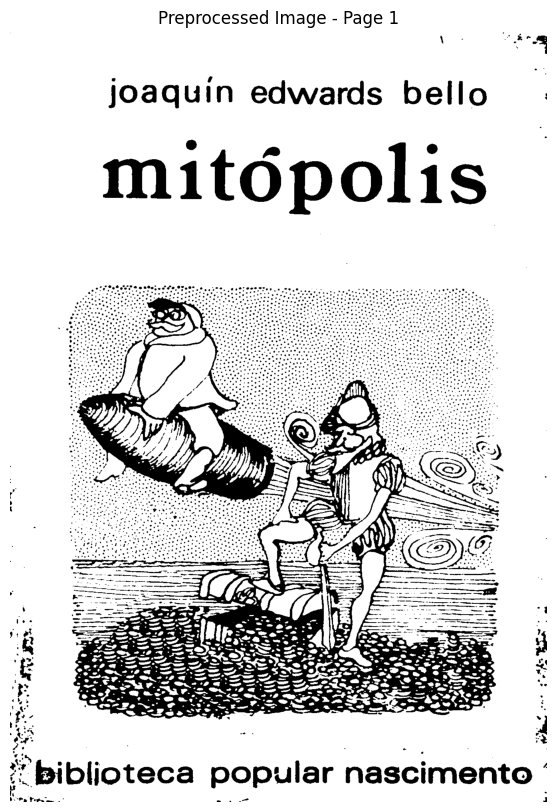

Page 1
Confidence: 51.95%
E. - 4 --   . ,   joaquin edwards bello :   mitópolis   Eo a Po A a  biblioteca popular nascimento   ea -
Page 1 may need manual review (low confidence).


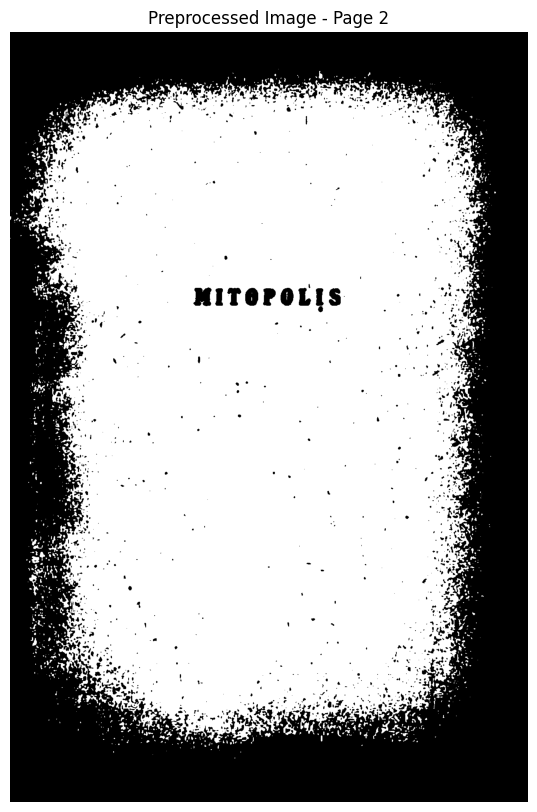

Page 2
Confidence: 38.01%
e ELA a RE MD ROAD e a EE  MA CA Mila E ALU e Ta zo TN  BEEN E  . 22 O , . l 5  DY e . . -. .. AN  a "4 - . e Aa  - . -. E  7. SLI . - ;  NT - PRE .  .. 2 . . 2. Leo  .. . . . -  : - - .  he KK , . .  . MITOPOLIS AA  , . 2  I NN . . "1.2  6: 7 - . 7D  -.. a. . ta ..: .  7 7 " - - -  2 138 . - - . . N . "O  ; O , . . a  ! al . , ..  , EY . E e ,  Pe AN N U ---- Nu  su E. . L . . . Po Mu  ¡PE 1 - . - "o  - -. CU 1 . . AN  .. CM 4 N . :-  Y o - - -- VA  dE E . - EUA ye-  A Un La .. e Rea  NP . , Nu  Mo Uy - - e  ¡2 TN Moa - - - . .. "5 2  --.. 00 ALE vá: Po NE e per 2:  . 27. Atos o INN E.  A - E e LA E MO ¿1 e fe E,  " UC "SN TO UC Cen Lar g SST  NA pe AAA NU Lu  - - NENA J 1 4 E. .
Page 2 may need manual review (low confidence).


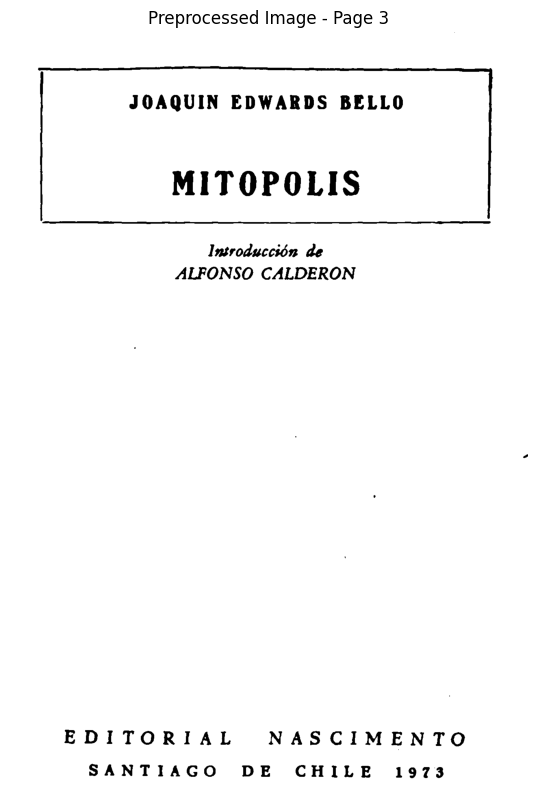

Page 3
Confidence: 90.64%
JOAQUIN EDWARDS BELLO  MITOPOLIS  Introducción de  ALFONSO CALDERON  EDITORIAL NASCIMENTO  SANTIAGO DE CHILE 1973


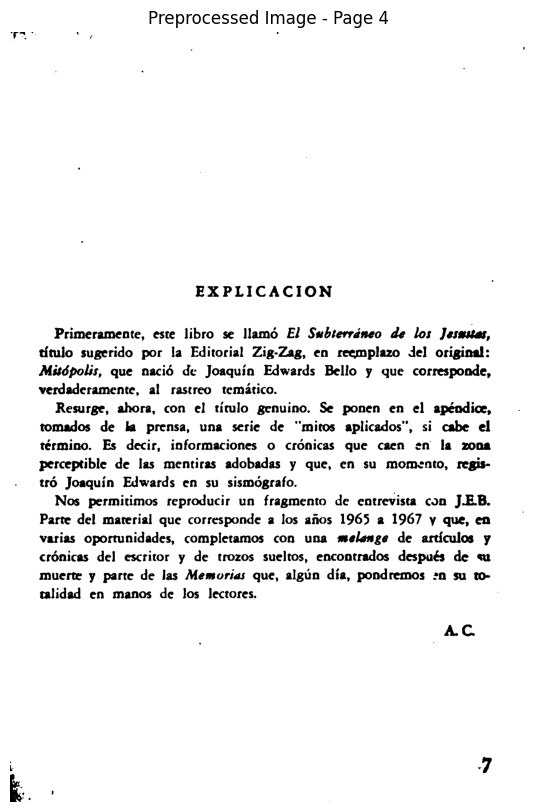

Page 4
Confidence: 92.01%
EXPLICACION   Primeramente, este libro se llamó El Subterráneo de los Jesustas,  tímlo sugerido por la Editorial Zig-Zag, en reemplazo del original:  Mssópolis, que nació de Joaquín Edwards Bello y que corresponde,  verdaderamente, al rastreo temático.   Resurge, ahora, con el título genuino. Se ponen en el apéndice,  tomados de la prensa, una serie de "mitos aplicados", si cabe el  término. Es decir, informaciones o crónicas que caen en la zona  perceptible de las mentiras adobadas y que, en su momento, regis-   .. tró Joaquín Edwards en su sismógrafo.   Nos permitimos reproducir un fragmento de entrevista con J.EB.  Parte del marerial que corresponde a los años 1965 a 1967 y que, en -  varias oportunidades, completamos con una melenge de artículos y  crónicas del escritor y de trozos sueltos, encontrados después de u  muerte y parte de las Memorias que, algún día, pondremos :n su to-  talidad en manos de los lectores.   AC


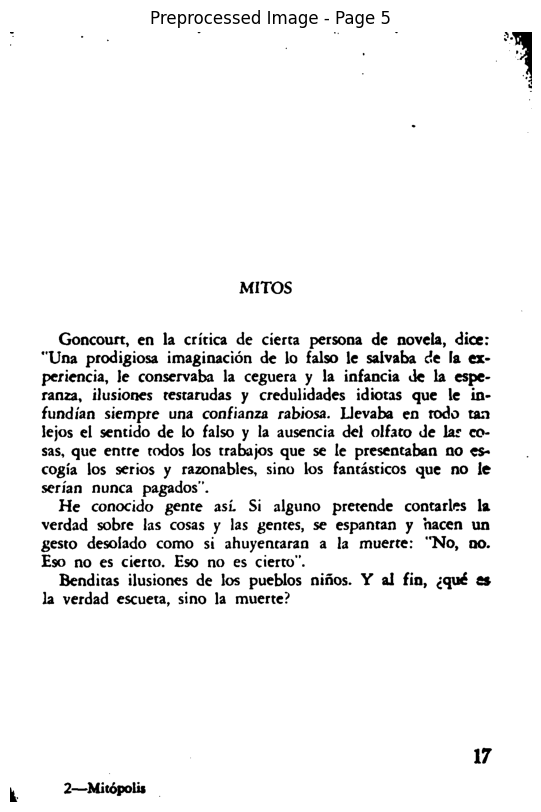

Page 5
Confidence: 92.64%
- . - E  MITOS   Goncourt, en la crítica de cierta persona de novela, dice:  "Una prodigiosa imaginación de lo falso le salvaba de la ex-  periencia, le conservaba la ceguera y la infancia de la espe-  ranza, ilusiones testarudas y credulidades idiotas que le in-  fundían siempre una confianza rabiosa. Llevaba en rodo tan  lejos el sentido de lo falso y la ausencia del olfato de las co-  sas, que entre todos los trabajos que se le presentaban no es- .  cogía los serios y razonables, sino los fantásticos que no le  serían nunca pagados".   He conocido gente así. Si alguno pretende contarles la  verdad sobre las cosas y las gentes, se espantan y nacen un  gesto desolado como si ahuyencaran a la muerte: "No, no.   Eso no es cierto. Eso no es cierto".   Benditas ilusiones de los pueblos niños. Y al fin, ¿qué es  la verdad escueta, sino la muerte?   17  " 2-Mitópolis


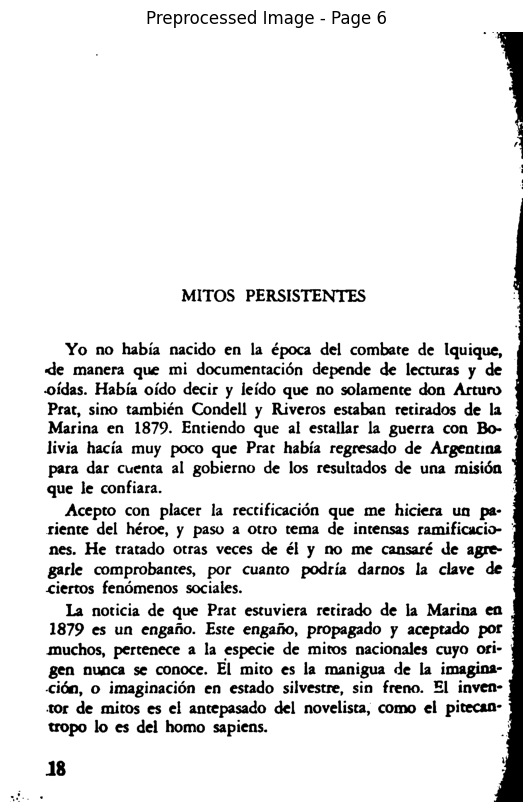

Page 6
Confidence: 92.66%
MITOS PERSISTENTES :   Yo no había nacido en la época del combate de lquique,  de manera que mi documentación depende de lecturas y de  oídas. Había oído decir y leído que no solamente don Arturo  Prar, sino también Condell y Riveros estaban retirados de la  Marina en 1879. Entiendo que al estallar la guerra con Bo-  livia hacía muy poco que Prat había regresado de Argentina  para dar cuenta al gobierno de los resultados de una misión  que le confiara.   Acepto con placer la rectificación que me hiciera un pa-  riente del héroe, y paso a otro tema de intensas ramificacio-  nes. He tratado otras veces de él y no me cansaré de agre-  garle comprobantes, por cuanto podría darnos la clave de  ciertos fenómenos sociales.   La noticia de que Prat estuviera retirado de la Marina en  1879 es un engaño. Este engaño, propagado y aceptado por  muchos, pertenece a la especie de mitos nacionales cuyo ori-  gen nunca se conoce. El mito es la manigua de la imagina-  ción, o 

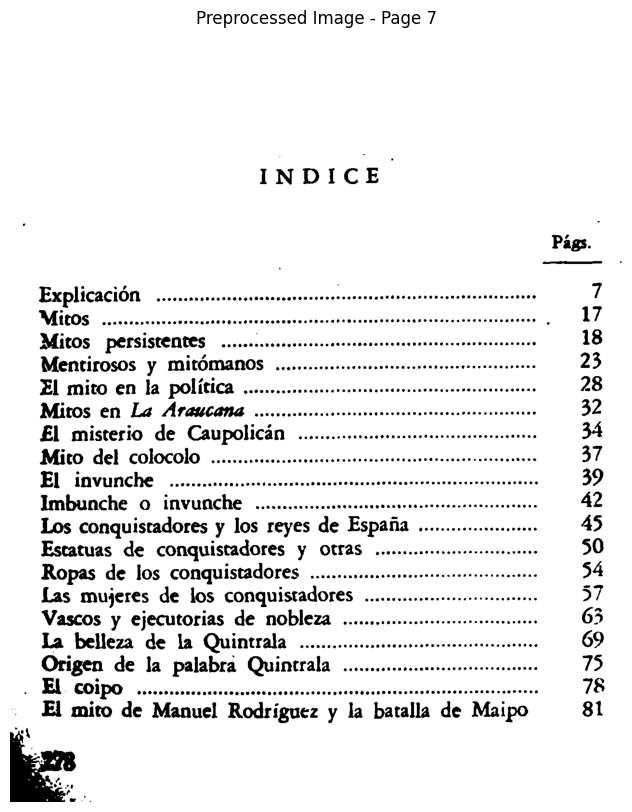

Page 7
Confidence: 84.69%
INDICE  Págs.  Explicación ...............remm60.0ne0ee0enene ee 7  Mitos persistentes ...................e0rore00000r0eenreoe can 18  Mentirosos y mitÓManos ................-e.-eeeeee e 23  El mito en la política .................-...e.ene0000ee nee e 28  Mitos en La AÁYaucana ................-.2eneemeeenenenen enanos 32  El misterio de Caupolicán ......................262e20000m 0. 34  Mito del colocolo ...................ere.eerereeeeere ene en 37  El invunche ...............-.e...oee0-0000eee Lee 39  Imbunche o invunche .....................eme0eee 42  Los conquistadores y los reyes de España ...................... 45  Estatuas de conquistadores y Otras .......................em..... 50  Ropas de los conquistadores ..........................20.e......... 54  Las mujeres de los conquistadores ................................ 37  Vascos y ejecutorias de nobleza ......................--.......... 63  La belleza de la Quintrala ....................e.eee.e.e200

In [31]:
import os
import fitz  # PyMuPDF for PDF handling
import cv2
import pytesseract
from PIL import Image
import numpy as np
import io
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from spellchecker import SpellChecker  # For post-processing

# Access the tesseract path
os.getenv('TESSDATA_PREFIX')


def preprocess_image(image):
    """
    Preprocess the image using a dynamic approach:
    - Use the old method for simpler pages.
    - Use the newer method for complex or low-contrast pages.
    """
    # Convert to grayscale
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    img_blur = cv2.GaussianBlur(grayscale, (5, 5), 0)

    # Apply Otsu's binarization
    _, img_binary = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img_binary

# OCR function with confidence scoring
def extract_text(image):
    """
    Extracts text and confidence scores from a preprocessed image using Tesseract OCR.
    """
    config = (
    "--oem 1 --psm 6 "
    "-c tessedit_char_whitelist=' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZáéíóúÁÉÍÓÚñÑ,.¡!¿?\\\"\\'():;-1234567890 "
)
    data = pytesseract.image_to_data(image, lang="spa", config=config, output_type=pytesseract.Output.DICT)
    
    text = " ".join(data["text"]).strip()
    confidence = np.mean([conf for conf in data["conf"] if conf > 0])  # Ignore invalid (-1) confidence values
    return text, confidence

# Post-processing function
def postprocess_text(text):
    """
    Cleans and corrects OCR text using spell-checking and basic formatting.
    """
    spell = SpellChecker(language="es")  # Spanish spell checker
    words = text.split()
    corrected_words = [
        spell.correction(word) if spell.correction(word) else word for word in words
    ]
    return " ".join(corrected_words)

# Title/Paragraph Detection (PyTorch placeholder)
def detect_text_regions(image):
    """
    Placeholder function to detect titles, paragraphs, or regions using PyTorch.
    You can expand this with pre-trained models for layout detection like Detectron2.
    """
    # Example: Mock segmentation with PyTorch transforms (future Detectron2 integration)
    transform = transforms.Compose([transforms.ToTensor()])
    tensor_image = transform(image)
    # Add PyTorch-based segmentation logic here
    return tensor_image  # Return for demonstration (expand as needed)

# Main pipeline to process a PDF
def process_pdf(pdf_path):
    """
    Extracts text from each page of a scanned book PDF and saves it to text files.
    """
    with fitz.open(pdf_path) as pdf_document:
        for page_num in range(pdf_document.page_count):
            # Load page as an image
            page = pdf_document.load_page(page_num)
            pix = page.get_pixmap(dpi=300)  # High-resolution image for OCR
            img = Image.open(io.BytesIO(pix.tobytes("png")))
            
            # Convert PIL image to OpenCV format
            open_cv_image = np.array(img)[:, :, ::-1]  # Convert RGB to BGR for OpenCV

            # Preprocess the image
            preprocessed_image = preprocess_image(open_cv_image)

            # Display the preprocessed image (for debugging)
            plt.figure(figsize=(10, 10))
            plt.imshow(preprocessed_image, cmap="gray")
            plt.title(f"Preprocessed Image - Page {page_num + 1}")
            plt.axis("off")
            plt.show()

            # Detect regions (placeholder)
            _ = detect_text_regions(preprocessed_image)

            # Extract text and confidence
            text, confidence = extract_text(preprocessed_image)

            # Post-process text
            #cleaned_text = postprocess_text(text)

            # Print text and confidence
            print(f"Page {page_num + 1}")
            print(f"Confidence: {confidence:.2f}%")
            print(text)

            # Flag for review if confidence is below threshold
            if confidence < 80:  # Adjust threshold as needed
                print(f"Page {page_num + 1} may need manual review (low confidence).")

# Example usage
pdf_path = "books/test2.pdf"  # Path to your PDF
process_pdf(pdf_path)